In [27]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

import numpy as np
import pandas as pd
import optuna
from tqdm import tqdm
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from joblib import Parallel, delayed

from utils import calc_metrics

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 41825352

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [12]:
X = pd.read_csv('../data/x.csv', index_col='date')
y = pd.read_csv('../data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

### Мешок слов плюс линейная модель

Создадим функцию для тестирования наших моделей. Зададим начальный порог и будем обучать, модель на наблюдениях до порога, а тестировать на одном наблюдении после. Двигая порог протестируем нашу модель. И потом сравним с истинными ответами. Качество всех наших моделей будем записывать в табличку.

Обучим логистическую регрессию с l1 регуляризацией, она нам покажет какие слова не влияют на предсказание модели.

In [13]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

bow = vectorizer.transform(X.release)

In [14]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    bow, y, LogisticRegression, name='bow l1 only release', plot=False,
    solver='liblinear', penalty='l1', C=c.item(), random_state=RANDOM_STATE
) for c in np.linspace(0.001, 10, 30))

roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=7.58644827586207, penalty='l1', random_state=41825352,
                   solver='liblinear')
ROC-AUC = 0.7704776154432906


Рассмотрим подробнее лучшую модель.

              precision    recall  f1-score   support

        -1.0       0.70      0.70      0.70        23
         0.0       0.52      0.58      0.55        26
         1.0       0.69      0.58      0.63        19

    accuracy                           0.62        68
   macro avg       0.63      0.62      0.62        68
weighted avg       0.63      0.62      0.62        68



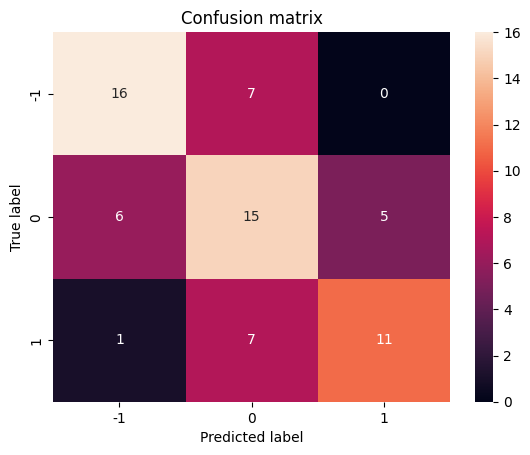

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478


In [15]:
metric, model = calc_metrics(bow, y, LogisticRegression, name='bow l1 only release', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Мы немного улучшили минимальный бейзлайн. Подберем гиперпараметры для elasticnet с помощью optuna, используя отбор слов при помощи логистической регрессии с L1-регуляризацией. Таким образом мы отбросим дополнительные признаки, которые не важны для этой модели.

In [40]:
def objective(trial, bow):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 0.01, 500),
        'C2': trial.suggest_float('C2', 0.01, 500),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.001, 1),
    }

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", SelectFromModel(estimator)),
        (
            "model",
            LogisticRegression(C=params["C2"], l1_ratio=params["l1_ratio"], solver='saga',
                                     penalty='elasticnet', max_iter=10000,
                                     random_state=RANDOM_STATE),
        ),
    ])

    # считаем метрики на кросс валидации
    try:
        metric, _ = calc_metrics(bow, y, pipeline, name=" ", plot=False, calc_jobs=-1)
    except ValueError or IndexError:
        return -np.inf

    return metric

# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, bow), n_trials=100, show_progress_bar=True)

Best trial: 38. Best value: 0.783063: 100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


Обучим лучшую модель и посмотрим ее оценки качества подробнее.

              precision    recall  f1-score   support

        -1.0       0.73      0.70      0.71        23
         0.0       0.50      0.58      0.54        26
         1.0       0.62      0.53      0.57        19

    accuracy                           0.60        68
   macro avg       0.62      0.60      0.61        68
weighted avg       0.61      0.60      0.61        68



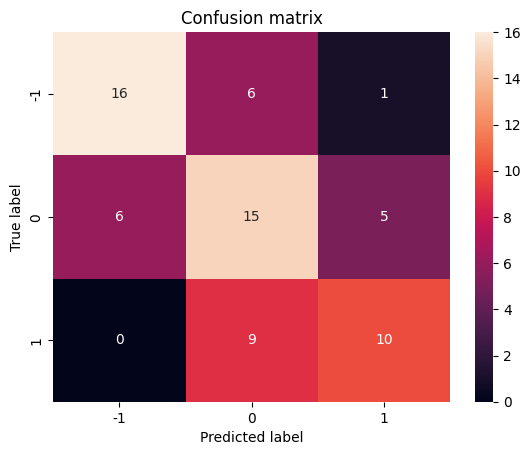

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478
bow elasticnet,0.602941,0.606085,0.617424,0.599630,0.779381,0.783093


In [29]:
estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, _ = calc_metrics(bow, y, pipeline, name='bow elasticnet')
metrics = pd.concat((metrics, metric))
metrics

Качество немного подросло. Попробуем обучить мешок слов не только на пресс-релизах, но и на названиях.

In [33]:
vectorizer_title = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer_title.fit(X.title)

bow_title = vectorizer_title.transform(X.title)

In [34]:
bow_title_release = np.concatenate((bow.toarray(), bow_title.toarray()), axis=1)

Подберем гиперпараметры для модели обучаемой на названии релиза и самом релизе.

In [41]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, bow_title_release), n_trials=100, show_progress_bar=True)

Best trial: 61. Best value: 0.786569: 100%|██████████| 100/100 [03:12<00:00,  1.93s/it]


Посмотрим на метрики модели и добавим их в таблицу.

              precision    recall  f1-score   support

        -1.0       0.68      0.65      0.67        23
         0.0       0.47      0.54      0.50        26
         1.0       0.62      0.53      0.57        19

    accuracy                           0.57        68
   macro avg       0.59      0.57      0.58        68
weighted avg       0.58      0.57      0.58        68



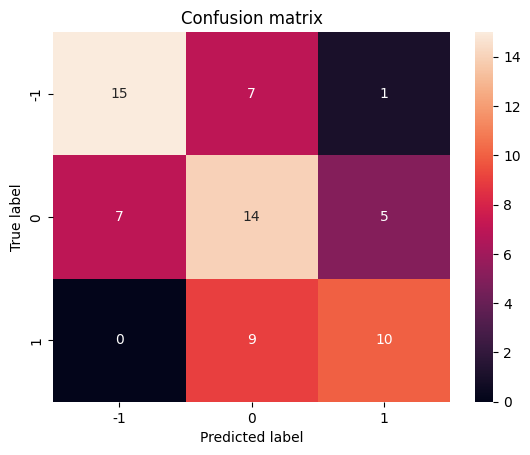

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478
bow elasticnet,0.602941,0.606085,0.617424,0.599630,0.779381,0.783093
bow release title,0.573529,0.579365,0.591162,0.572317,0.782876,0.786569


In [42]:
estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, _ = calc_metrics(
    bow_title_release, y, 
    pipeline, 
    name='bow release title'
)

metrics = pd.concat([metrics, metric])
metrics

Добавление мешка слов по названию ухудшает качество модели по метрике accuracy, при улучшении по ROC-AUC. Попробуем к мешку слов по текстам релизов, с самыми важными словами добавим количественные признаки.

In [43]:
num_columns = ['inflation', 'rate', 'usd', 'usd_cur_change_relative']

scaler = StandardScaler()
scaler.fit(X[num_columns])
X[num_columns] = scaler.transform(X[num_columns])

In [44]:
all_data = np.concatenate((bow_title_release, X[num_columns].values), axis=1)

In [45]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, all_data), n_trials=100, show_progress_bar=True)

Best trial: 99. Best value: 0.781362: 100%|██████████| 100/100 [03:37<00:00,  2.17s/it]


              precision    recall  f1-score   support

        -1.0       0.68      0.65      0.67        23
         0.0       0.47      0.54      0.50        26
         1.0       0.62      0.53      0.57        19

    accuracy                           0.57        68
   macro avg       0.59      0.57      0.58        68
weighted avg       0.58      0.57      0.58        68



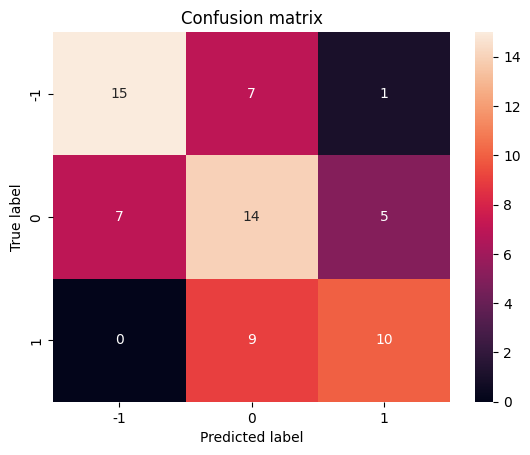

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478
bow elasticnet,0.602941,0.606085,0.617424,0.599630,0.779381,0.783093
bow release title,0.573529,0.579365,0.591162,0.572317,0.782876,0.786569
bow release all num,0.573529,0.579365,0.591162,0.572317,0.776894,0.781362


In [46]:
estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, _ = calc_metrics(
    all_data, y, 
    pipeline, 
    name='bow release all num'
    )

metrics = pd.concat([metrics, metric])
metrics

Добавление количественных переменных только ухудшило нашу модель. Попробуем на мешке слов обученный на релизах обучить SVC.

In [51]:
def objective(trial, bow):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 0.01, 500),
        'C2': trial.suggest_float('C2', 0.01, 500),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    }

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", SelectFromModel(estimator)),
        (
            "model",
            SVC(C=params["C2"], kernel=params['kernel'], probability=True, random_state=RANDOM_STATE),
        ),
    ])

    # считаем метрики на кросс валидации
    try:
        metric, _ = calc_metrics(bow, y, pipeline, name=" ", plot=False, calc_jobs=-1)
    except ValueError or IndexError:
        return -np.inf

    return metric

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, bow), n_trials=200, show_progress_bar=True)

Best trial: 146. Best value: 0.790207: 100%|██████████| 200/200 [00:59<00:00,  3.35it/s]


              precision    recall  f1-score   support

        -1.0       0.73      0.70      0.71        23
         0.0       0.52      0.58      0.55        26
         1.0       0.71      0.63      0.67        19

    accuracy                           0.63        68
   macro avg       0.65      0.63      0.64        68
weighted avg       0.64      0.63      0.64        68



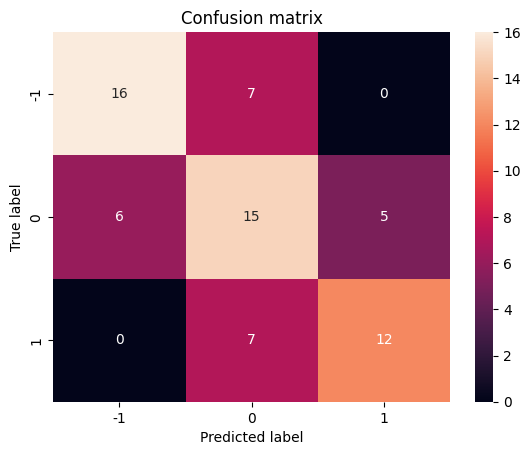

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478
bow elasticnet,0.602941,0.606085,0.617424,0.599630,0.779381,0.783093
bow release title,0.573529,0.579365,0.591162,0.572317,0.782876,0.786569
bow release all num,0.573529,0.579365,0.591162,0.572317,0.776894,0.781362
bow svc only release,0.632353,0.641077,0.650132,0.634718,0.784936,0.790207


In [52]:
estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        SVC(C=study.best_params["C2"], kernel=study.best_params['kernel'],
            probability=True, random_state=RANDOM_STATE),
    ),
])

metric, _ = calc_metrics(
    bow, y, 
    pipeline, 
    name='bow svc only release', 
    )

metrics = pd.concat([metrics, metric])
metrics

Метод опорных векторов показал качество лучше, чем логистическая регрессия. Сохраним результаты экспериментов.

In [53]:
metrics.to_csv('metrics.csv')